Universidad Torcuato Di Tella

Licenciatura en Tecnología Digital\
**Tecnología Digital VI: Inteligencia Artificial**


In [ ]:
%pip install --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cpu


In [76]:
%pip install pydub scikit-learn wandb torchview torchviz graphviz matplotlib tqdm


  Using cached tqdm-4.66.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.66.1-py3-none-any.whl (78 kB)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import torch
import torchaudio
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchaudio.datasets import GTZAN
from torch.utils.data import DataLoader
import torchaudio.transforms as tt
from torch.utils.data import random_split
import matplotlib
import matplotlib.pyplot as plt
import gc
from sklearn.metrics import accuracy_score, confusion_matrix
import torch.nn.functional as F
from torch.utils.data import DataLoader
import IPython
from tqdm import tqdm


import wandb
wandb.login()

%matplotlib inline



# TP3: Encodeador de música



## Orden de pasos

0. Elijan GPU para que corra mas rapido (RAM --> change runtime type --> T4 GPU)
1. Descargamos el dataset y lo descomprimimos en alguna carpeta en nuestro drive.
2. Conectamos la notebook a gdrive y seteamos data_dir con el path a los archivos.
3. Visualización de los archivos
4. Clasificación
5. Evaluación




In [131]:
project_name='TP4'


### 2. Conectamos la notebook a gdrive y seteamos data_dir con el path a los archivos.





In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')


data_dir es el path donde pusimos la carpeta genres. "'//content/drive/MyDrive/Materias/TD6 - Inteligencia Artificial/TPs/2023/TP4/genres/'" es un ejemplo. Modificar.

In [6]:
import os
data_dir='data/genres_5sec/'
list_files=os.listdir(data_dir)
classes=[]
for file in list_files:
  name='{}/{}'.format(data_dir,file)
  if os.path.isdir(name):
    classes.append(file)
classes


['pop',
 'metal',
 'disco',
 'blues',
 'reggae',
 'classical',
 'rock',
 'hiphop',
 'country',
 'jazz']

In [245]:
samplerate=22050
def parse_genres(fname):
    parts = fname.split('/')[-1].split('.')[0]
    return parts #' '.join(parts[0])

class MusicDataset(Dataset):
    def __init__(self, root):
        super().__init__()
        self.root = root
        self.files =[]
        for c in classes:
          self.files = self.files + [fname for fname in os.listdir(os.path.join(root,c)) if fname.endswith('.wav')]
        self.classes = list(set(parse_genres(fname) for fname in self.files))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        fname = self.files[i]

        #img = self.transform(open_image(fpath))
        genre = parse_genres(fname)
        fpath = os.path.join(self.root,genre, fname)
        class_idx = self.classes.index(genre)
        audio = torchaudio.load(fpath)[0]

        spectogram = tt.Spectrogram()(audio)

        # MelSpectrogram tt.MelSpectrogram(sample_rate=samplerate, n_fft=1024, hop_length=512, n_mels=128)(audio)
        mel_spectogram = tt.MelSpectrogram(sample_rate=samplerate, n_fft=1024, hop_length=200, n_mels=201)(audio)

        return audio, spectogram, mel_spectogram, class_idx
    
    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        fmt_str += '    Root Location: {}\n'.format(self.root)
        # List classes
        fmt_str += '    Classes: {}\n'.format(self.classes)
        return fmt_str

dataset = MusicDataset(data_dir)

random_seed = 42
torch.manual_seed(random_seed);
val_size = 100
test_size = 100
train_size = len(dataset) - val_size - test_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds), len(test_ds)

batch_size = 10

train_dl = DataLoader(train_ds, batch_size, shuffle=True, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size*2, pin_memory=True)
test_dl = DataLoader(test_ds,1, pin_memory=True)

dataset


Dataset MusicDataset
    Number of datapoints: 990
    Root Location: data/genres_5sec/
    Classes: ['country', 'hiphop', 'metal', 'reggae', 'pop', 'disco', 'rock', 'jazz', 'blues', 'classical']

In [175]:
sample = next(iter(train_dl))
sample[0].shape, sample[1].shape


(torch.Size([10, 1, 110250]), torch.Size([10, 1, 201, 552]))

### 3. Visualización de los archivos

shape of waveform torch.Size([1, 110250]), sample rate with 22050, label is 4 
shape of spectogram torch.Size([1, 201, 552])


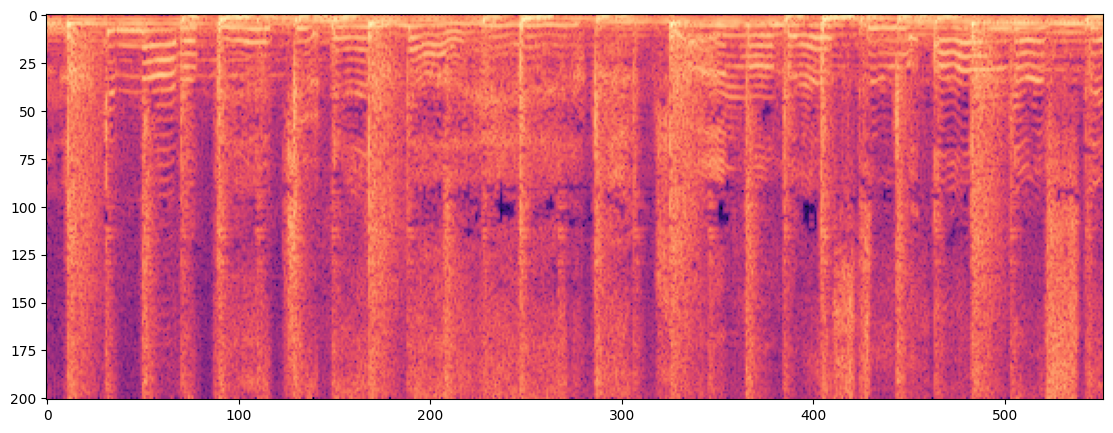

In [246]:
waveform, spectogram, mel_spectogram, label = dataset[0]
wf_shape = waveform.shape

print("shape of waveform {}, sample rate with {}, label is {} ".format(wf_shape, samplerate, label))

print("shape of spectogram {}".format(spectogram.size()))

plt.figure(figsize=(20, 5))

plt.imshow(spectogram.log2()[0,:,:].numpy(),cmap='magma')


shape of spectogram torch.Size([1, 201, 552])


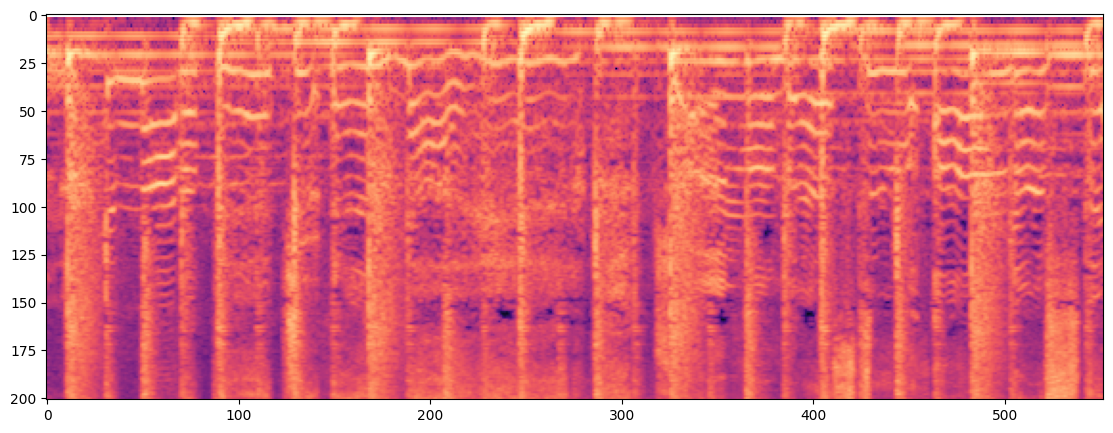

In [247]:
# MelSpectrogram
# waveform, _, label = dataset[0]

# mel_spectogram = tt.MelSpectrogram(sample_rate=samplerate, n_fft=1024, hop_length=512, n_mels=128)(waveform)
# To make it have twice the resolution
mel_spectogram = tt.MelSpectrogram(sample_rate=samplerate, n_fft=1024, hop_length=200, n_mels=201)(waveform)

print("shape of spectogram {}".format(mel_spectogram.size()))

plt.figure(figsize=(20, 5))

plt.imshow(mel_spectogram.log2()[0,:,:].numpy(),cmap='magma')


Waveform: tensor([[ 0.0345,  0.0482,  0.0643,  ..., -0.1070, -0.0598, -0.0341]])



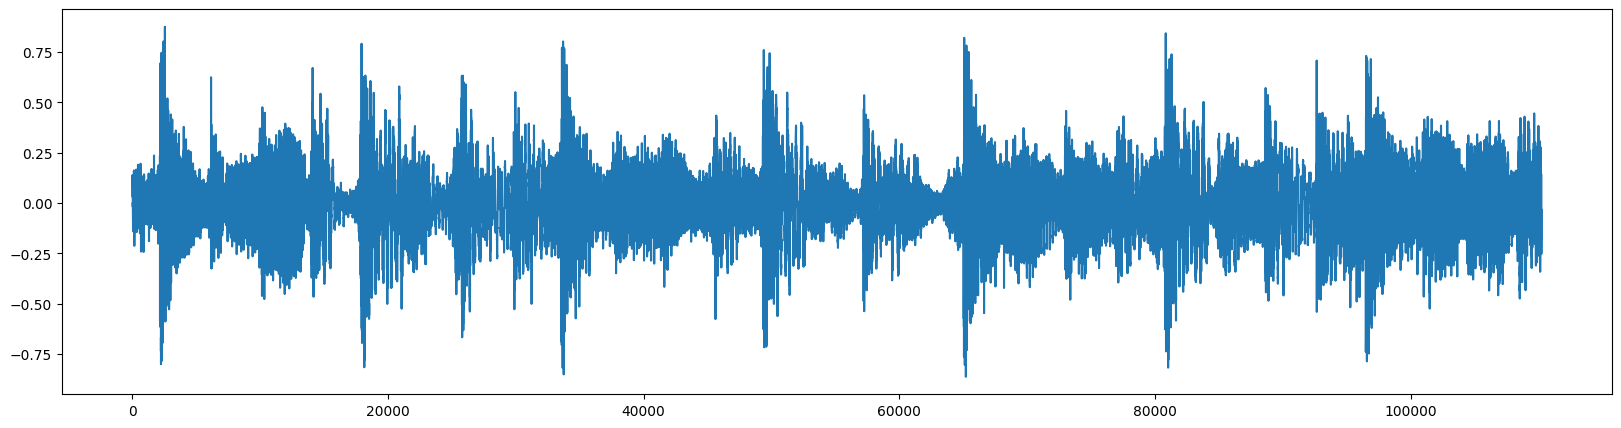

In [248]:
print("Waveform: {}\n".format(waveform))


plt.figure(figsize=(20, 5))
plt.plot(waveform.t().numpy())


Escuchamos el espectograma con la librería de audio

In [249]:
IPython.display.Audio(waveform,rate=samplerate)


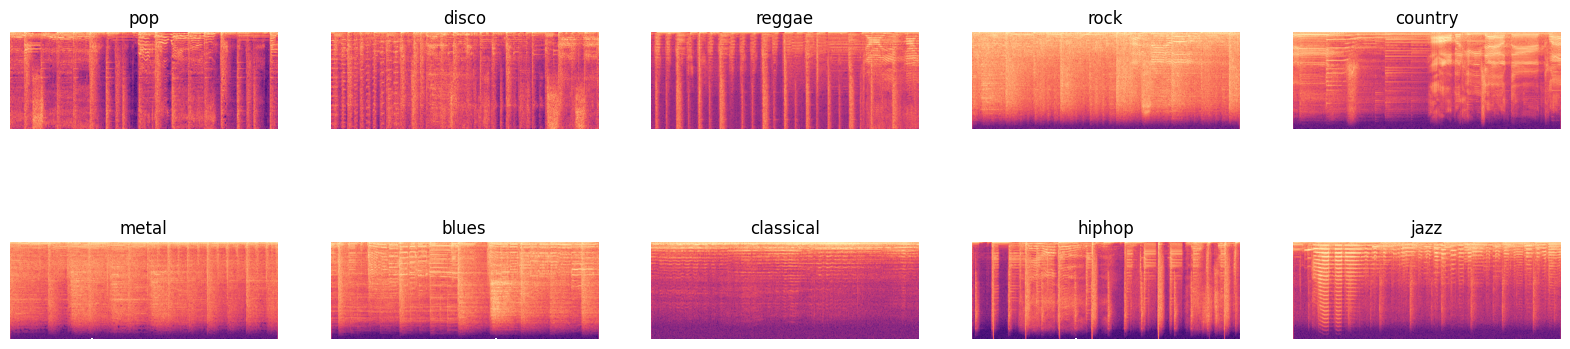

In [234]:
# Visualize one spectogram from each class

fig, axs = plt.subplots(2, len(classes)//2, figsize=(20, 5))

sample_audios = []

for i, c in enumerate(classes):
    paths = [fname for fname in os.listdir(os.path.join(data_dir, c)) if fname.endswith('.wav')]
    fname = paths[np.random.randint(len(paths))]
    fpath = os.path.join(data_dir, c, fname)
    sample_audios.append((c, fpath))
    audio = torchaudio.load(fpath)[0]
    specgram = tt.Spectrogram()(audio)
    axs[i%2, i//2].imshow(specgram.log2()[0,:,:].numpy(),cmap='magma') 
    axs[i%2, i//2].set_title(c)
    axs[i%2, i//2].axis('off')

plt.show()


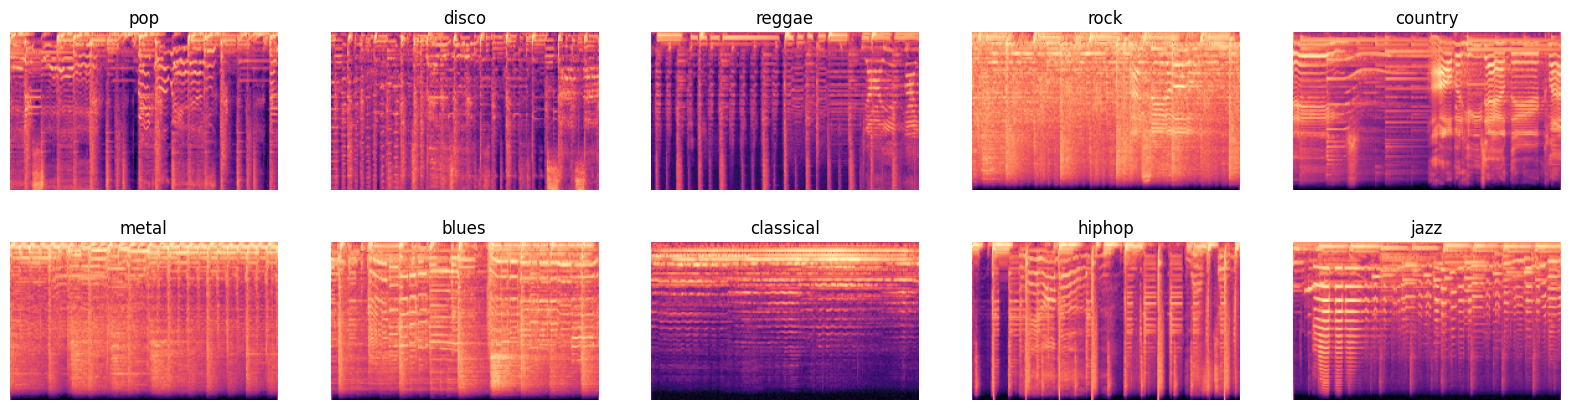

In [235]:
# Visualize one spectogram from each class

fig, axs = plt.subplots(2, len(classes)//2, figsize=(20, 5))

# MelSpectrogram for each audio sample

for i, (c, fpath) in enumerate(sample_audios):

    audio = torchaudio.load(fpath)[0]
    specgram = tt.MelSpectrogram(sample_rate=samplerate, n_fft=1024, hop_length=512, n_mels=128)(audio)
    axs[i%2, i//2].imshow(specgram.log2()[0,:,:].numpy(),cmap='magma') 
    axs[i%2, i//2].set_title(c)
    axs[i%2, i//2].axis('off')

plt.show()


In [236]:
# Display players for each audio sample
# In an html table of 2 rows and 5 columns

audios_html = "<table><tr>"
for i, (c, fpath) in enumerate(sample_audios):
    audios_html += "<td><center><b>{}</b></center><br>".format(c)
    audios_html += "<audio controls><source src='{}'></audio>".format(fpath)
    audios_html += "</td>"
    if (i+1)%5 == 0:
        audios_html += "</tr><tr>"

IPython.display.HTML(audios_html)


pop,metal,disco,blues,reggae
classical,rock,hiphop,country,jazz


In [181]:
specgram.size()


torch.Size([1, 201, 552])

### 4. Clasificación

In [69]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


In [99]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


In [182]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(1, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc1 = nn.Linear(6144, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)

        return x


In [183]:
device = torch.device(
    'mps:0' if torch.backends.mps.is_available() else 'cuda:0' if torch.cuda.is_available() else 'cpu'
    )

device


device(type='mps', index=0)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [251]:
#model = M5(n_input=1, n_output=len(classes)).to(device)

model = ResNet(ResidualBlock, [2, 2, 2, 2]).to(device)

n = count_parameters(model)
print("Number of parameters: %s" % n)


Number of parameters: 17477770


In [102]:
len(classes)


10

In [252]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()
elif torch.backends.mps.is_available():
    torch.mps.empty_cache()

gc.collect() # importante para ir liberando memoria ram

val_loss = 0
val_acc = 0
train_acc = 0

lr = 0.0005

loss_function = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []
num_epochs = 30

wandb.init(
    project=project_name, 
    name=f"{model.__class__.__name__}_lr={lr}_bs={batch_size}_epochs={num_epochs},{device}",
)

# IPython clear cell output
# IPython.display.clear_output()

iterator = tqdm(range(num_epochs), total=num_epochs, desc="Epoch")

for epoch in iterator:
    train_losses_itter = []

    total = 0
    train_correct = 0

    # Train
    model.train()
    for wav, _, spectogram, genre_index in train_dl:
        
        optimizer.zero_grad()  # Clear gradients
        spectogram = spectogram.to(device)
        genre_index = torch.as_tensor(genre_index).to(device)

        # Forward
        out = model(spectogram)
        #M5
        loss = loss_function(out.squeeze(), genre_index)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses_itter.append(loss.item())
        
        pred = out.argmax(dim=-1).flatten()
        train_correct += (pred == genre_index).sum().item()
        total += len(pred)
        train_acc = 100 * train_correct / total

        del spectogram #importante para ir liberando memoria ram
        del genre_index #importante para ir liberando memoria ram
        del loss #importante para ir liberando memoria ram
        del out  #importante para ir liberando memoria ram
        
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        elif torch.backends.mps.is_available():
            torch.mps.empty_cache()

        gc.collect() #importante para ir liberando memoria ram
        

        iterator.set_postfix_str(
            {
                "Train loss": round(np.mean(train_losses_itter), 4),
                "Train accuracy": round(train_acc, 4),
                "Valid loss": round(val_loss, 4),
                "Valid accuracy": round(val_acc, 4),
            }
        )

        train_losses.append(np.mean(train_losses_itter))

    #print('Epoch: [%d/%d], Train loss: %.4f' % (epoch+1, num_epochs, np.mean(losses)))

    # Validation
    model.eval()
    y_true = []
    y_pred = []
    val_losses_itter = []
    correct =0
    for wav, _, spectogram, genre_index in valid_dl:
        #print(wav, genre, index)
        spectogram = spectogram.to(device)
        genre_index = genre_index.to(device)

        out = model(spectogram)
        #M5
        loss = loss_function(out.squeeze(), genre_index)

        val_losses_itter.append(loss.item())

        #M5
        pred = out.argmax(dim=-1).flatten()
        
        #print(pred)
        #print(genre_index)
        
        # append labels and predictions
        #pred.eq(genre_index).sum().item()
        correct += (pred == genre_index).sum().item()
        y_true.extend(genre_index)
        y_pred.extend(pred)

        del spectogram #importante para ir liberando memoria ram
        del genre_index #importante para ir liberando memoria ram
        del loss #importante para ir liberando memoria ram
        del out  #importante para ir liberando memoria ram
        
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        elif torch.backends.mps.is_available():
            torch.mps.empty_cache()

        gc.collect() #importante para ir liberando memoria ram

    #accuracy = correct / len(valid_dl.dataset)
    val_acc = 100 * correct / len(valid_dl.dataset)
    val_loss = np.mean(val_losses_itter)

    #print('Epoch: [%d/%d], Valid loss: %.4f, Valid accuracy: %.4f' % (epoch+1, num_epochs, val_loss, accuracy))


    iterator.set_postfix_str(
        {
            "Train loss": round(np.mean(train_losses)),
            "Train accuracy": round(train_acc),
            "Valid loss": round(val_loss),
            "Valid accuracy": round(val_acc),
        }
    )

    wandb.log(
        {
            "Train loss": np.mean(train_losses),
            "Train accuracy": train_acc,
            "Valid loss": val_loss,
            "Valid accuracy": val_acc,
        }
    )

    # Save model
    train_losses.append(np.mean(train_losses))
    train_accs.append(train_acc)
    valid_losses.append(val_loss.item())
    valid_accs.append(val_acc)

    #if np.argmin(valid_losses) == epoch:
    #    print('Saving the best model at %d epochs!' % epoch)
    #    torch.save(model.state_dict(), 'best_model.ckpt')

wandb.finish()


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Train accuracy,▁▂▃▅▅▆▆▇█████
Train loss,█▇▆▅▄▃▃▃▂▂▁▁▁
Valid accuracy,▆▁▇▆▂▆▃▅▇▄█▇▄
Valid loss,▁▆▂▁▆▃█▄▆█▁▄▆
Train accuracy,89.74684
Train loss,0.74584
Valid accuracy,42.0
Valid loss,2.3056


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]/Users/nacho/Desktop/code/TP4_TDVI/.conda/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (201) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(
Epoch:  43%|████▎     | 13/30 [11:28<14:33, 51.41s/it, {'Train loss': 0.4189, 'Train accuracy': 85.7895, 'Valid loss': 2.6218, 'Valid accuracy': 34.0}]



### 5. Evaluación



In [97]:
# Load the best model
#S = torch.load('best_model.ckpt')
#model.load_state_dict(S)
print('loaded!')

# Run evaluation
model.eval()
y_true = []
y_pred = []
correct = 0
with torch.no_grad():
    for spectogram, genre_index in test_dl:
        spectogram = spectogram.to(device)
        genre_index = genre_index.to(device)

        out = model(spectogram)

        pred = out.argmax(dim=-1).flatten()
        # append labels and predictions
        correct += pred.eq(genre_index).sum().item()
        y_true.extend(genre_index)
        y_pred.extend(pred)

accuracy = correct / len(test_dl.dataset)
print('Epoch: [%d/%d], Valid loss: %.4f, Valid accuracy: %.4f' % (epoch+1, num_epochs, val_loss, accuracy))


loaded!
Epoch: [30/30], Valid loss: 1.9323, Valid accuracy: 0.5600


In [ ]:
waveform,label= test_dl.dataset[12]
print("shape of waveform {}, sample rate with {}, label is {} ".format(waveform.size(),samplerate,label))


In [ ]:
import IPython
IPython.display.Audio(waveform, rate=22050)


In [ ]:
spectogram= torch.unsqueeze(waveform, dim=0)
model.to(device)
spectogram = spectogram.to(device)
out = model(spectogram)
pred = out.argmax(dim=-1).flatten()
classes[pred], classes[label]
